In [29]:
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import plotly.express as px
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Установка необходимых библиотек
!pip install datasets

# Загрузка набора данных
datasets = load_dataset("dair-ai/emotion")

# Загрузка обучающих, тестовых и валидационных данных
train_data = datasets['train']
test_data = datasets['test']
validation_data = datasets['validation']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/3 [00:00<?, ?it/s]

# EDA

In [31]:
# Проверка количества строк и столбцов
print("DataFrame содержит " + str(train_data.shape[0]) + " образцов и " + str(train_data.shape[1]) + " столбцов")


DataFrame содержит 16000 образцов и 2 столбцов


# EDA

In [32]:
# Удаление дубликатов
train_df = train_data.to_pandas()
duplicates = train_df['text'].duplicated().sum()
print("Дубликаты в наборе данных: " + str(duplicates))
train_df = train_df.drop_duplicates(subset='text')
print("Дубликаты в наборе данных: " + str(train_df.duplicated().sum()))


Дубликаты в наборе данных: 31
Дубликаты в наборе данных: 0


In [33]:
# Проверка пропущенных значений и типов данных
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15969 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15969 non-null  object
 1   label   15969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 374.3+ KB


In [34]:
# Преобразование меток классов в текстовые описания
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_df['description'] = train_df['label'].map(labels_dict)


In [35]:
# Визуализация распределения длины текстов
train_df['length_of_text'] = [len(i.split(' ')) for i in train_df['text']]
fig = px.histogram(train_df['length_of_text'], marginal='box',
                   labels={"value": "Длина текста"})
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Распределение длины текстов',
                  title_x=0.5, title_font=dict(size=22))
fig.show()

In [36]:
# Визуализация частоты слов
FreqOfWords = train_df['text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]
fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text='Частота слов в обучающем наборе данных',
                  title_x=0.5, title_font=dict(size=22))
fig.update_traces(textinfo="label+value")
fig.show()

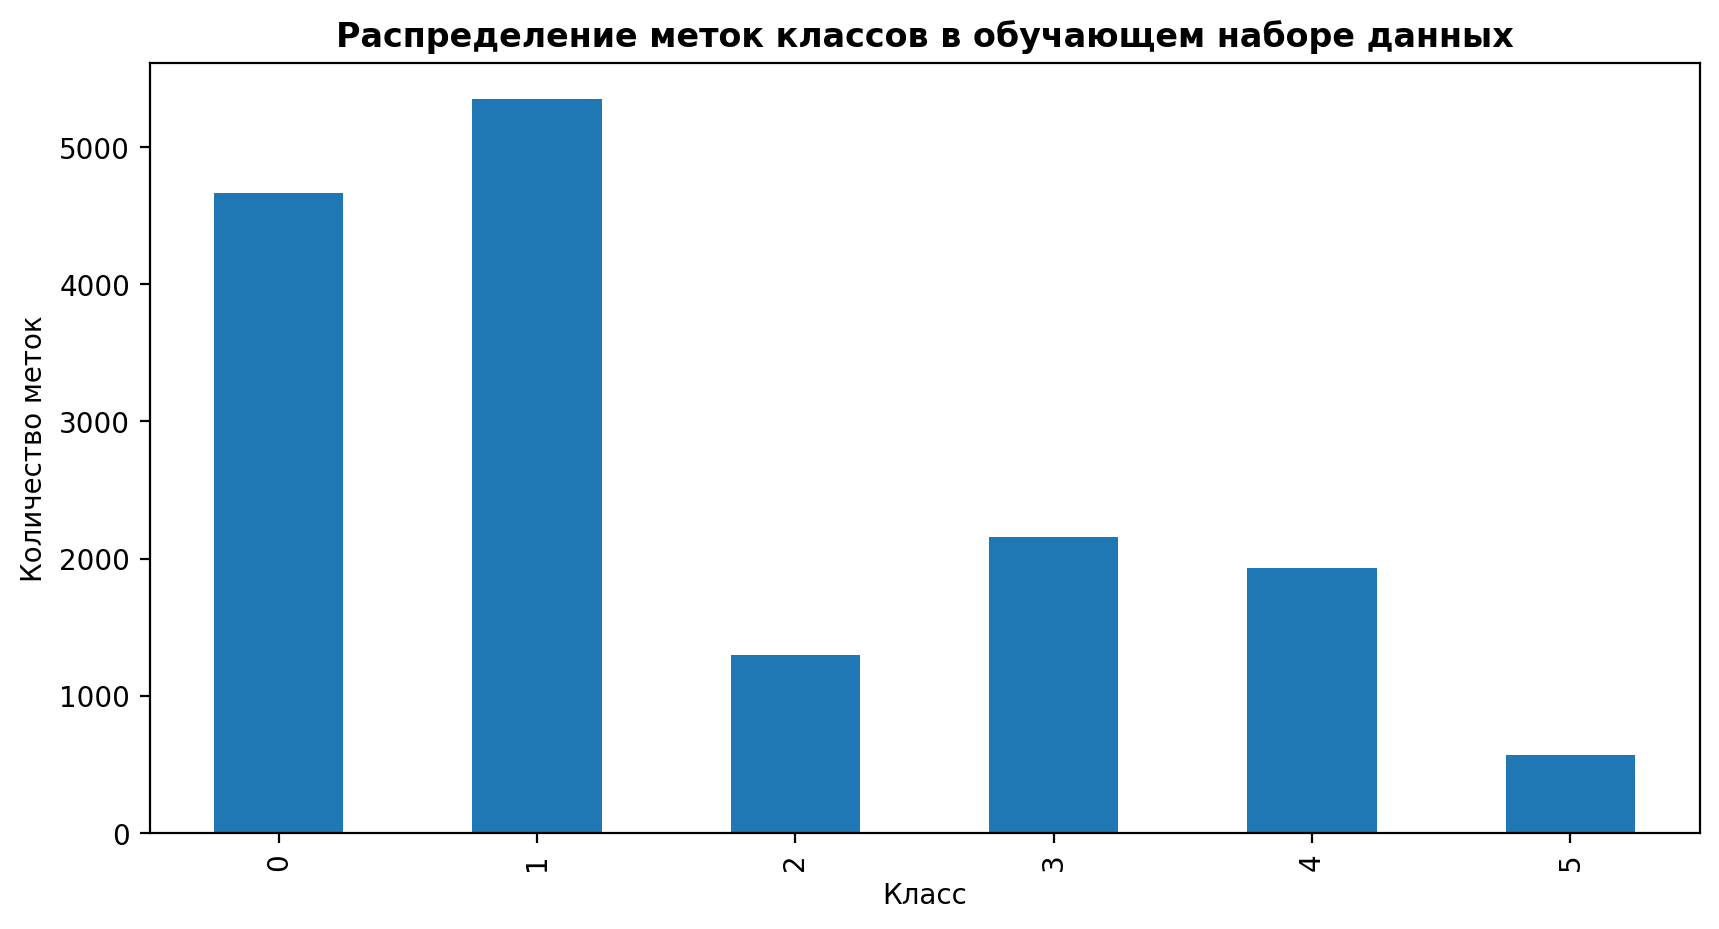

In [37]:
# Проверка баланса меток классов
train_df['label'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Распределение меток классов в обучающем наборе данных', fontweight="bold")
plt.xlabel('Класс')
plt.ylabel('Количество меток')
plt.show()

# Создание набора стоп-слов
stopwords_english = set(stopwords.words('english'))
my_stopwords = set(["http", "'s", "n't", "'m", "'re", "'ve"])
stopwords_english.update(my_stopwords)

In [38]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_df['description'] = train_df['label'].map(labels_dict )
train_df.head(10)

,text,label,description,length_of_text
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
5,ive been feeling a little burdened lately wasn...,0,sadness,12
6,ive been taking or milligrams or times recomme...,5,surprise,23
7,i feel as confused about life as a teenager or...,4,fear,17
8,i have been with petronas for years i feel tha...,1,joy,19
9,i feel romantic too,2,love,4


In [39]:
# Функция для предобработки текста
def preprocess_review(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление чисел
    text = re.sub(r'\d+', '', text)

    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)

    # Разделение текста на токены
    tokens = text.split()

    # Фильтрация токенов
    clean_tokens = [tok for tok in tokens if tok not in stopwords_english and len(tok) > 1]

    # Объединение токенов в строку
    clean_text = ' '.join(clean_tokens)

    return clean_text

In [40]:
# Пример предобработки текста
sample = train_df['text'][22]
print('ОРИГИНАЛЬНЫЙ ТЕКСТ:   ' + sample + '\n')
print('---------------------------------------------------------------------------- \n')
print('ПОСЛЕ ПРЕДОБРАБОТКИ:    ' + preprocess_review(sample))


ОРИГИНАЛЬНЫЙ ТЕКСТ:   i have the feeling she was amused and delighted

---------------------------------------------------------------------------- 

ПОСЛЕ ПРЕДОБРАБОТКИ:    feeling amused delighted


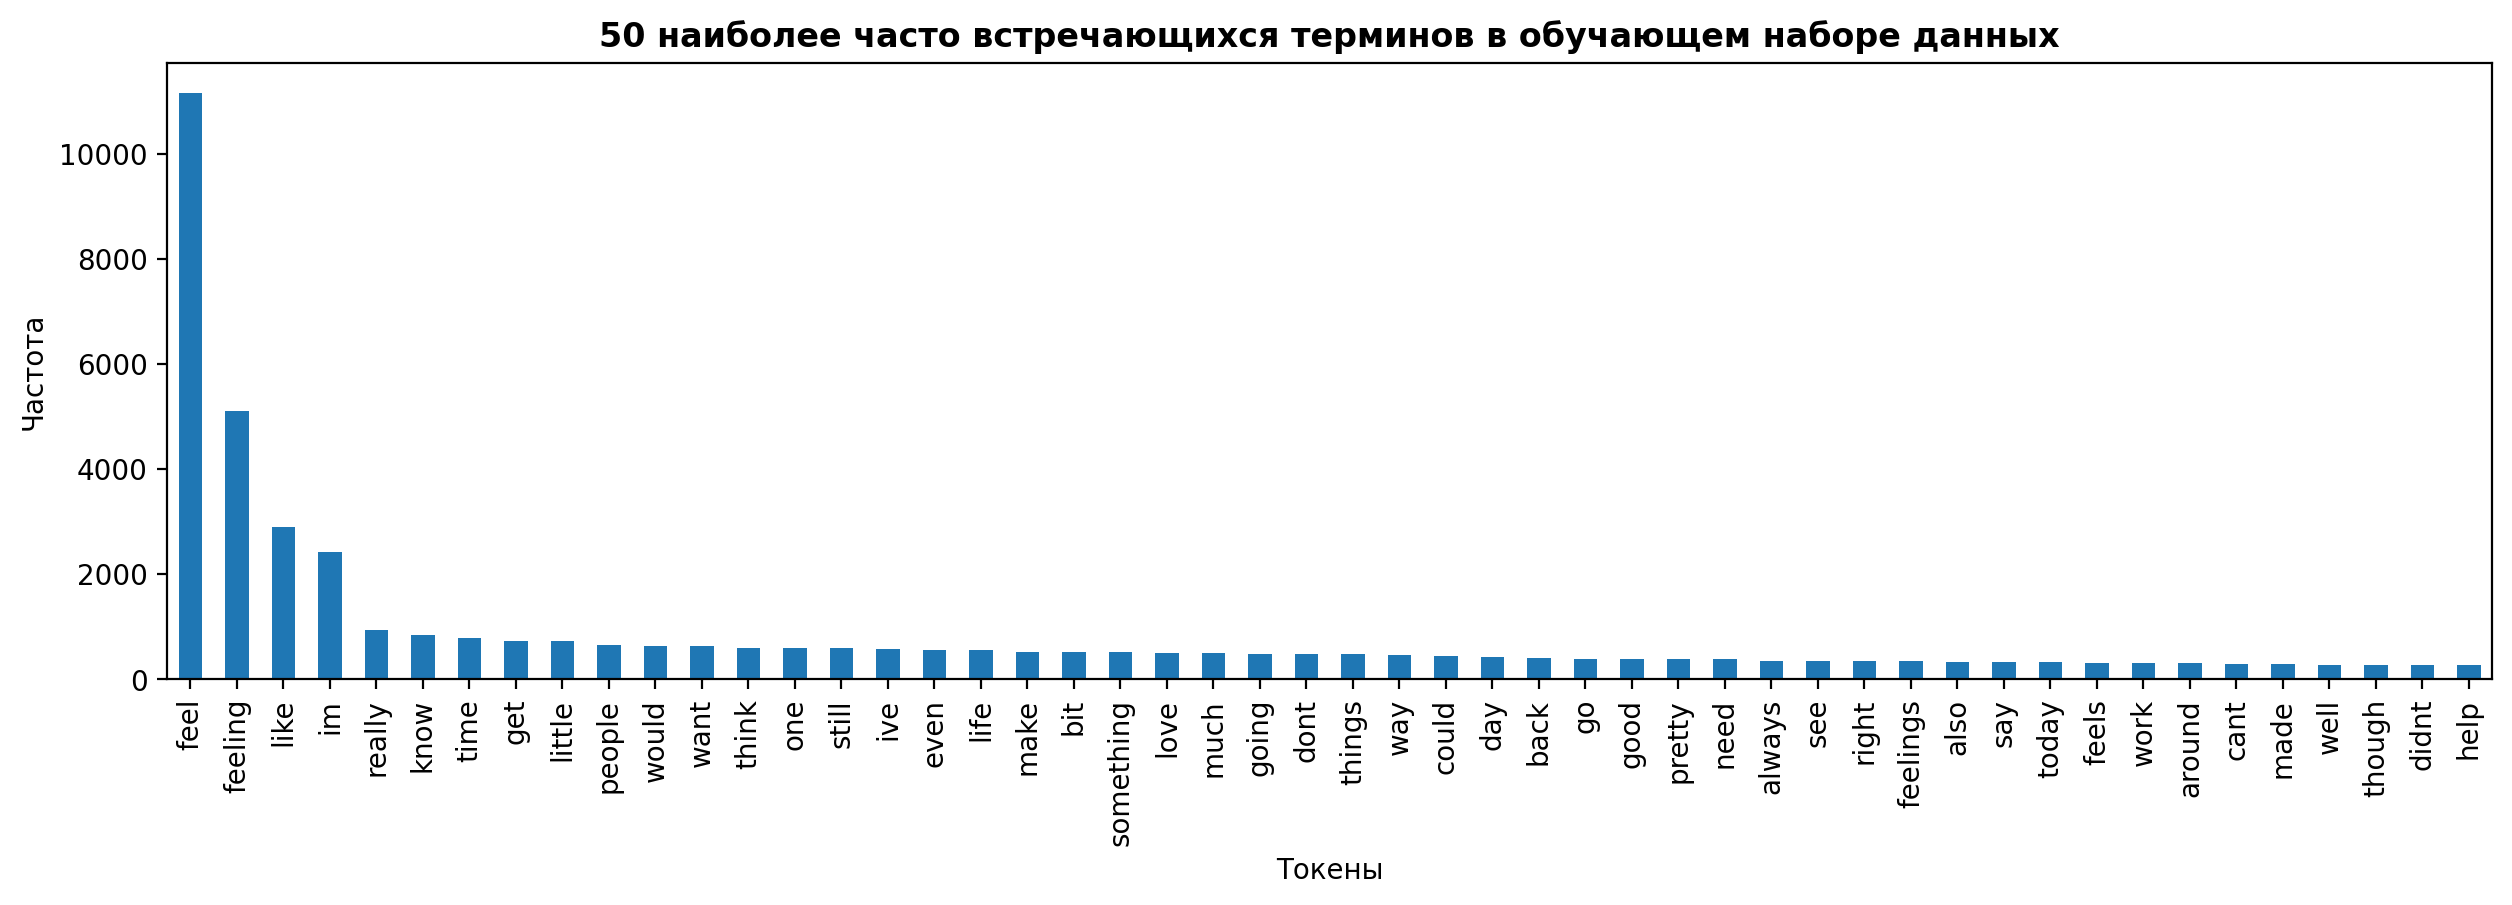

In [41]:
# Предобработка обучающих данных и добавление нового столбца
train_df["clean_text"] = train_df["text"].apply(preprocess_review)

# Визуализация 50 наиболее часто встречающихся слов
frequent_words = pd.Series(' '.join(train_df.clean_text).split()).value_counts()[:50]
frequent_words.plot.bar(figsize=(15,4))
plt.title('50 наиболее часто встречающихся терминов в обучающем наборе данных', fontweight="bold")
plt.xlabel('Токены')
plt.ylabel('Частота')
plt.show()


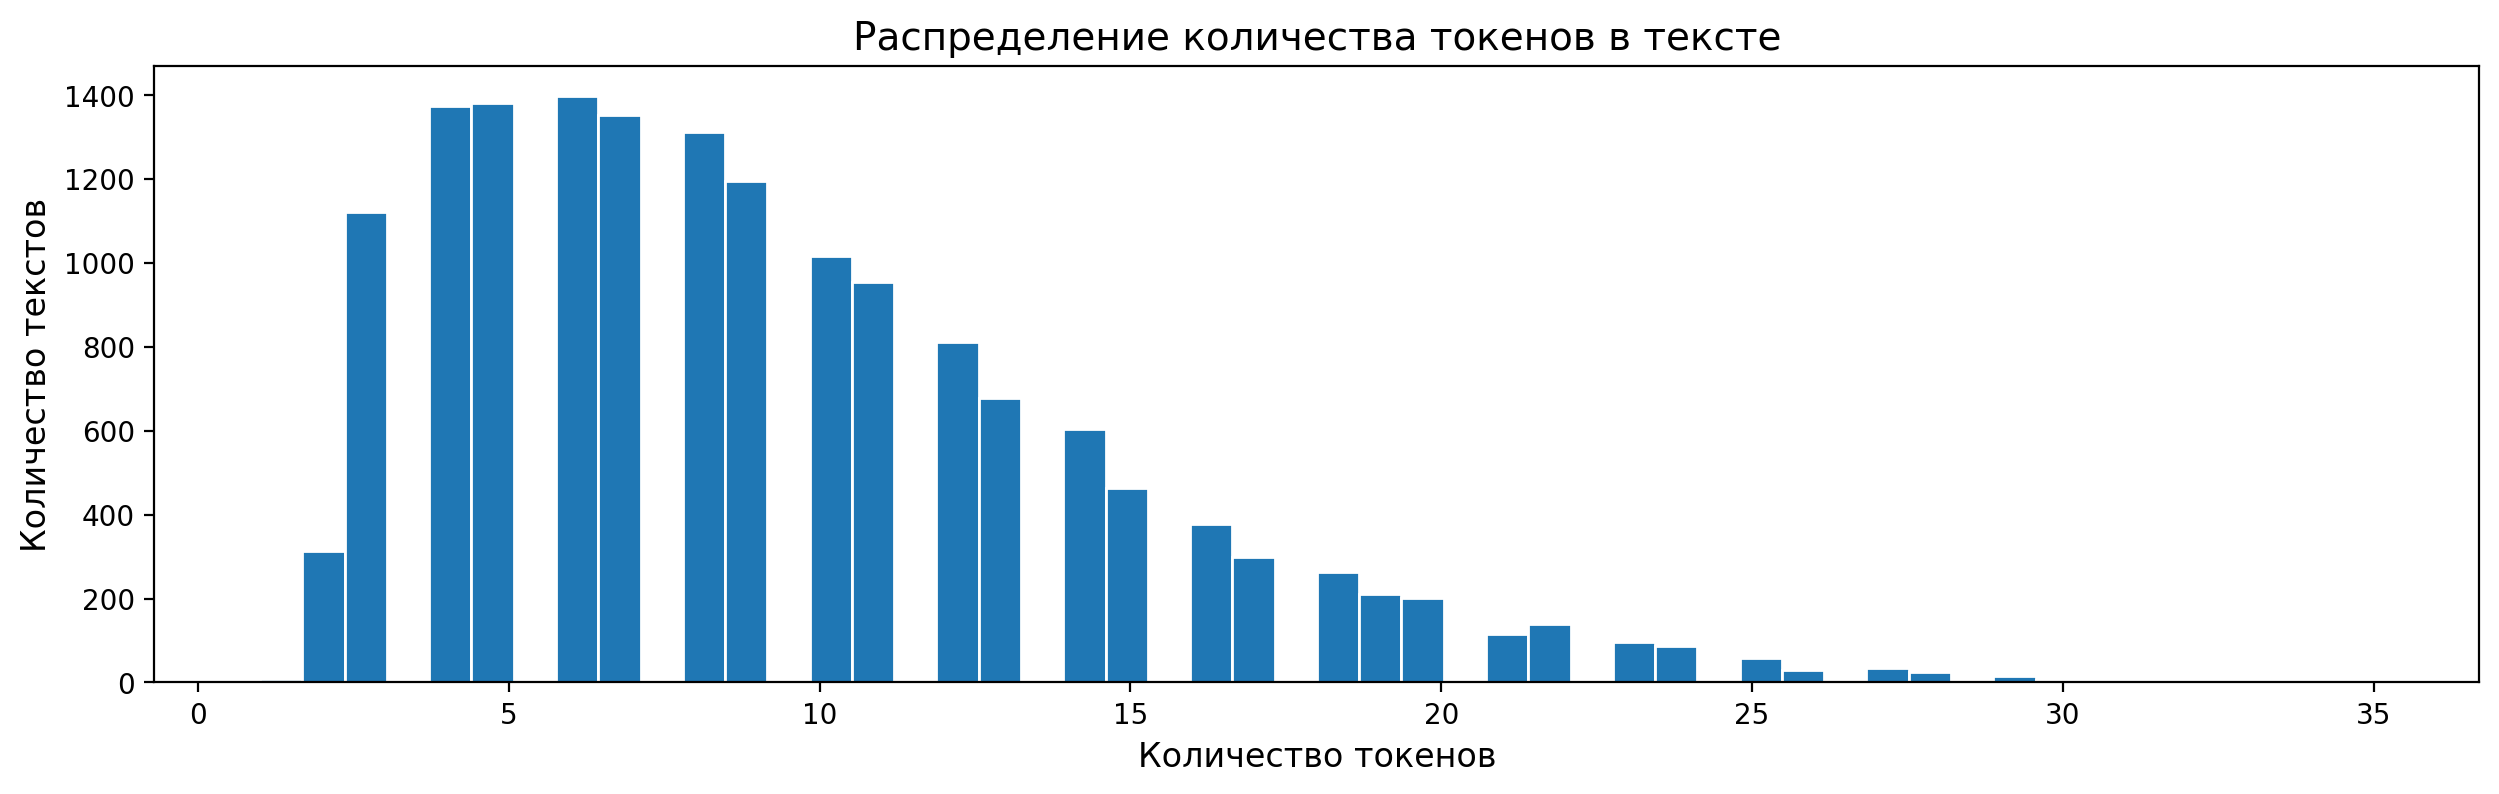

In [42]:
# Очистка памяти
del frequent_words
gc.collect()

# Визуализация количества токенов в очищенных отзывах
plt.figure(figsize=(15,4))
plt.hist(train_df['clean_text'].apply(lambda x:len(x.split())), bins=50, edgecolor='white')
plt.xlabel('Количество токенов', fontsize=12)
plt.ylabel('Количество текстов',fontsize=12)
plt.title('Распределение количества токенов в тексте', fontsize=14)
plt.show()


In [43]:
# Удаление исходного столбца с текстом
train = train_df.drop(columns=['text'])


In [44]:
# Получение нескольких записей для проверки работы
train.head()

,label,description,length_of_text,clean_text
0,0,sadness,4,didnt feel humiliated
1,0,sadness,21,go feeling hopeless damned hopeful around some...
2,3,anger,10,im grabbing minute post feel greedy wrong
3,2,love,18,ever feeling nostalgic fireplace know still pr...
4,3,anger,4,feeling grouchy


# Тестовый набор данных

In [45]:
# Тестовый набор данных

test_df = test_data.to_pandas()
test_df["clean_text"] = test_df["text"].apply(preprocess_review)
test_df = test_df.drop(columns=["text"])
test_df.head()

,label,clean_text
0,0,im feeling rather rotten im ambitious right
1,0,im updating blog feel shitty
2,0,never make separate ever want feel like ashamed
3,1,left bouquet red yellow tulips arm feeling sli...
4,0,feeling little vain one


In [46]:


# Создание массивов X и y
from sklearn.model_selection import train_test_split

# Обучающие данные
X_train = train_df["clean_text"].values
y_train = train_df["label"].values


# Разделение данных

In [47]:
# Создание массивов X и y
from sklearn.model_selection import train_test_split

# Обучающие данные
X_train = train_df["clean_text"].values
y_train = train_df["label"].values

# Разделение на обучающий и проверочный наборы данных
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Тестовые данные
X_te = test_df["clean_text"].values

print("Данные для обучения:", X_tr.shape, y_tr.shape)
print("Данные для проверки:", X_va.shape, y_va.shape)
print("Тестовые данные:", X_te.shape)

Данные для обучения: (12775,) (12775,)
Данные для проверки: (3194,) (3194,)
Тестовые данные: (2000,)


# Модель

In [48]:
# Токенизация и заполнение последовательностей
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_tr)

max_seq_length = 250

X_tr_seq = tokenizer.texts_to_sequences(X_tr)
X_tr_seq = pad_sequences(X_tr_seq, maxlen=max_seq_length)

X_va_seq = tokenizer.texts_to_sequences(X_va)
X_va_seq = pad_sequences(X_va_seq, maxlen=max_seq_length)

X_te_seq = tokenizer.texts_to_sequences(X_te)
X_te_seq = pad_sequences(X_te_seq, maxlen=max_seq_length)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=250))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=128)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 1e-4),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['acc']
                 )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          2560000   
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 124, 64)          0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 124, 128)         66048     
 nal)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 124, 128)         512       
 hNormalization)                                                 
                                                      

In [50]:
%%time

history = model.fit(X_tr_seq,
                    y_tr,
                    validation_data=(X_va_seq, y_va),
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                   )

Epoch 1/15
200/200 [==============================] - 241s 1s/step - loss: 2.2395 - acc: 0.1897 - val_loss: 1.8145 - val_acc: 0.2877
Epoch 2/15
200/200 [==============================] - 210s 1s/step - loss: 1.8732 - acc: 0.2745 - val_loss: 1.8127 - val_acc: 0.2934
Epoch 3/15
200/200 [==============================] - 212s 1s/step - loss: 1.3460 - acc: 0.5025 - val_loss: 1.4314 - val_acc: 0.4571
Epoch 4/15
200/200 [==============================] - 213s 1s/step - loss: 0.8419 - acc: 0.7203 - val_loss: 0.8718 - val_acc: 0.7019
Epoch 5/15
200/200 [==============================] - 211s 1s/step - loss: 0.5454 - acc: 0.8356 - val_loss: 0.7825 - val_acc: 0.7483
Epoch 6/15
200/200 [==============================] - 213s 1s/step - loss: 0.3830 - acc: 0.8892 - val_loss: 0.5846 - val_acc: 0.8015
Epoch 7/15
200/200 [==============================] - 205s 1s/step - loss: 0.2971 - acc: 0.9210 - val_loss: 0.6402 - val_acc: 0.7937
Epoch 8/15
200/200 [==============================] - 220s 1s/step - 

In [64]:
import pickle

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [63]:
import plotly.express as px

# Создание графика значений потерь
fig1 = px.line(history.history, y=['loss', 'val_loss'], labels={'index': 'эпоха', 'value': 'значение потерь'})
fig1.update_layout(
    title="График значений потерь",
    xaxis_title="эпоха",
    yaxis_title="значение потерь",
    legend_title="Тип",
)

# Создание графика точности
fig2 = px.line(history.history, y=['acc', 'val_acc'], labels={'index': 'эпоха', 'value': 'точность'})
fig2.update_layout(
    title="График точности",
    xaxis_title="эпоха",
    yaxis_title="точность",
    legend_title="Тип",
)

# Отображение графиков
fig1.show()
fig2.show()


In [52]:
test_loss, test_acc = model.evaluate(X_va_seq,y_va)

print('Потери на проверке:', test_loss)
print('Точность на проверке:', test_acc)

100/100 [==============================] - 20s 194ms/step - loss: 0.5425 - acc: 0.8391
Потери на проверке: 0.5424706339836121
Точность на проверке: 0.8390732407569885


In [53]:
# Вычисление предсказаний на проверочном наборе данных
pred = [np.argmax(i) for i in model.predict(X_va_seq)]


100/100 [==============================] - 22s 199ms/step


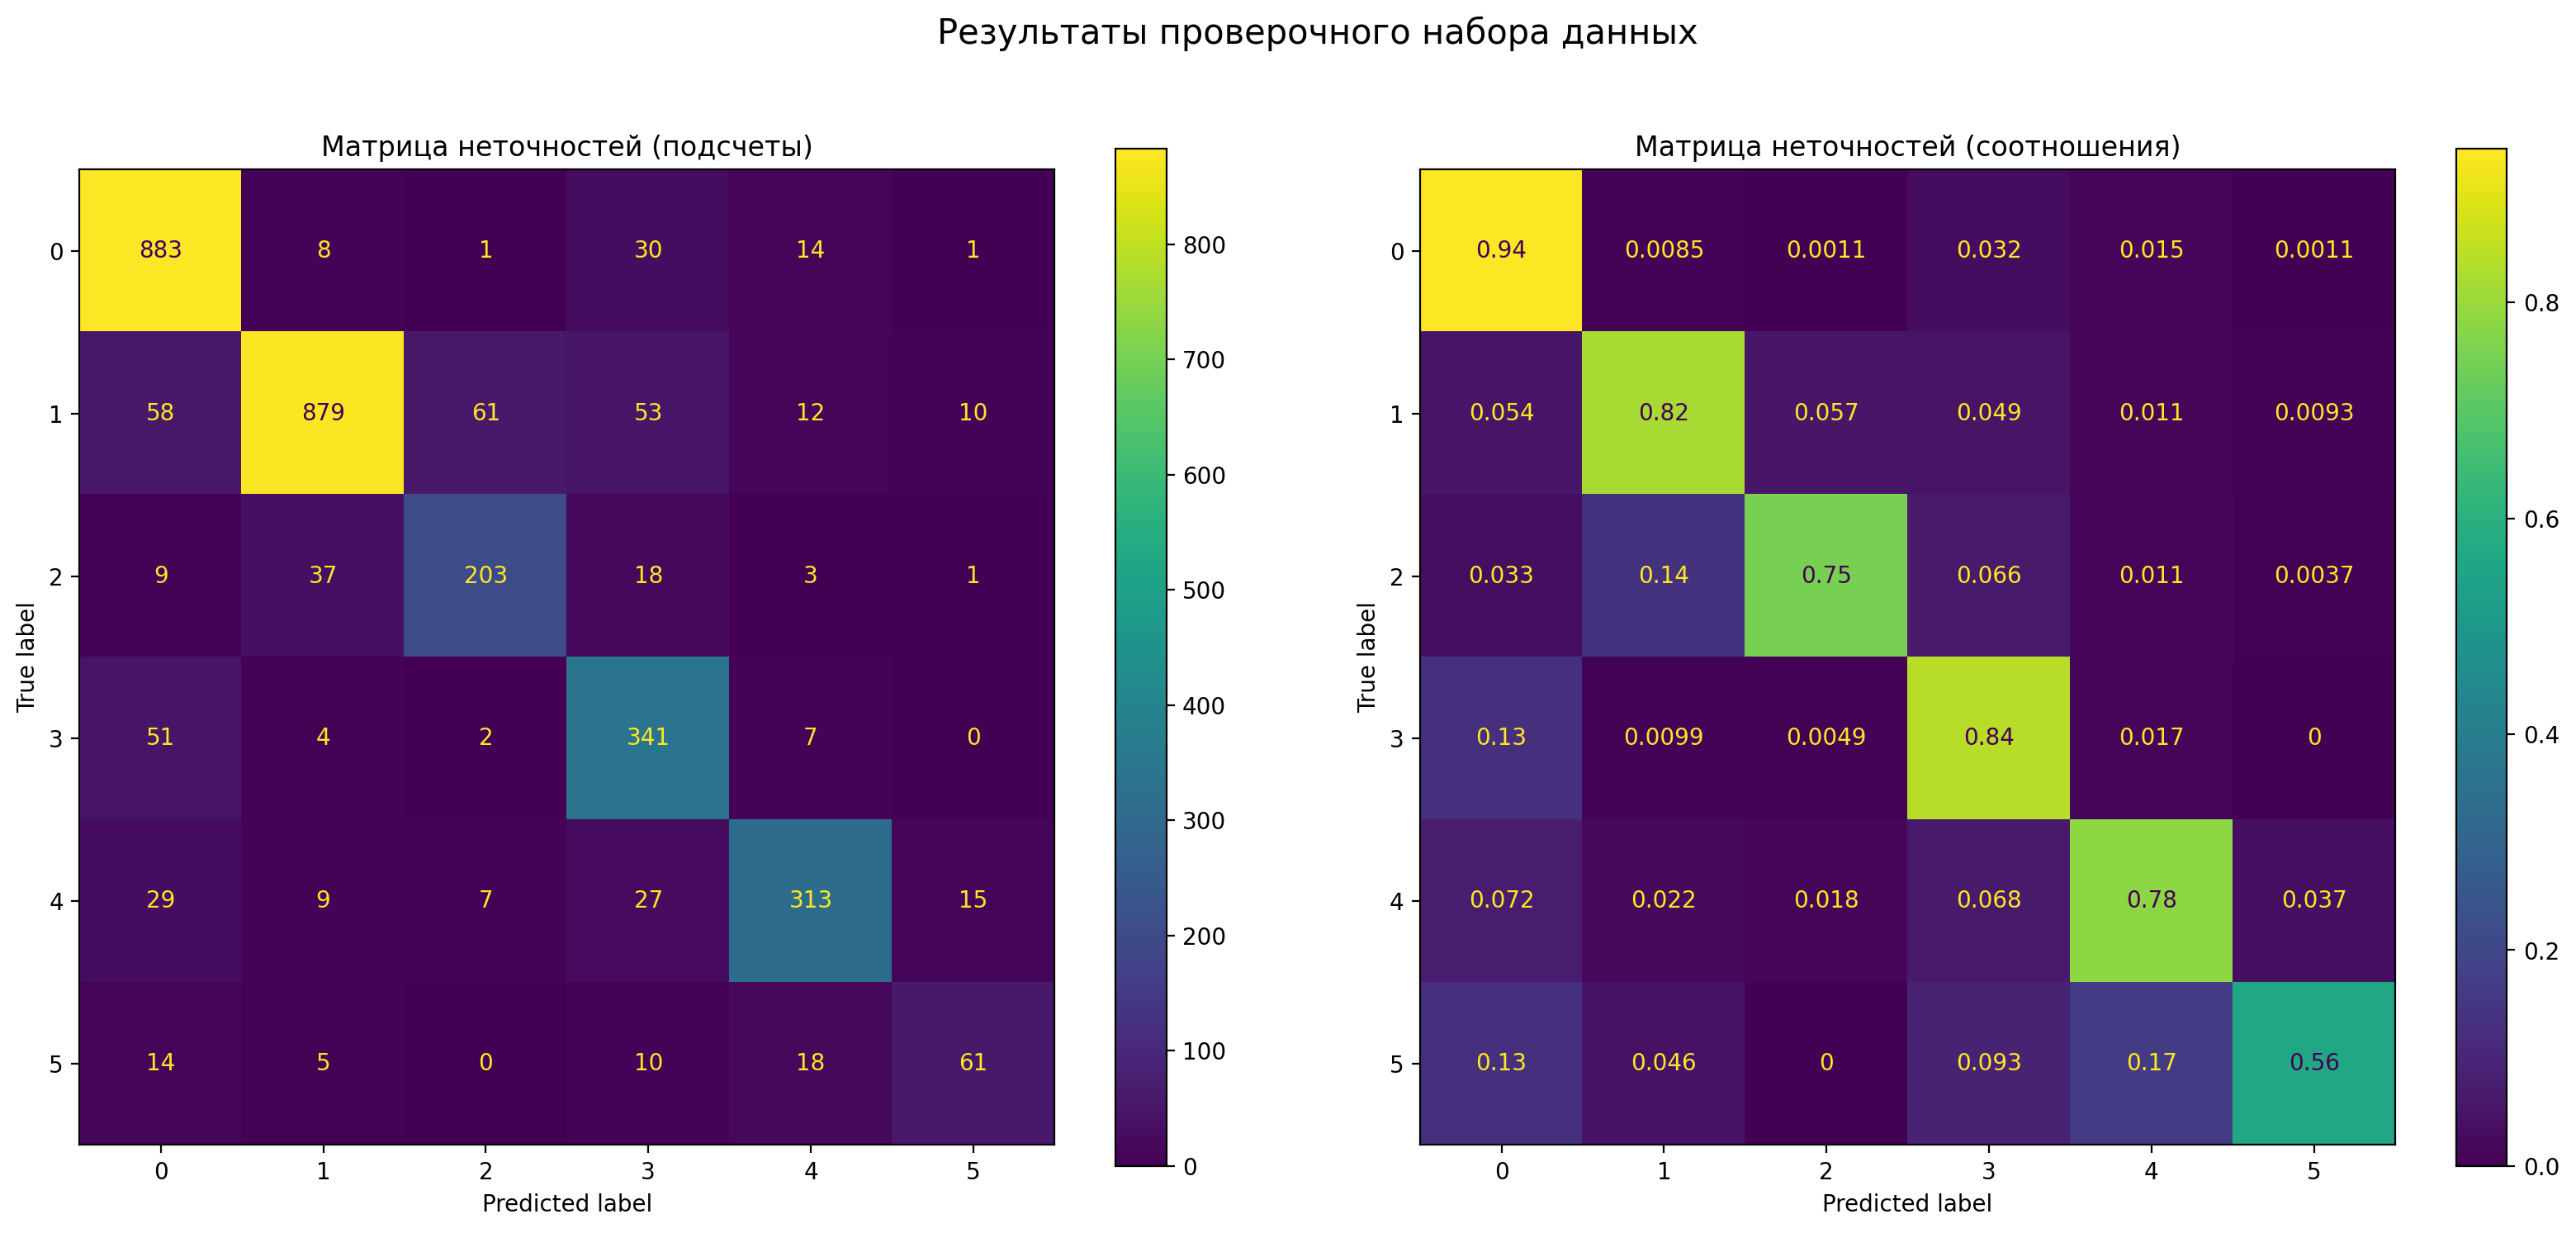

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Вычисление матрицы неточностей по исходным значениям
cm_raw = confusion_matrix(y_va, pred)

# Вычисление матрицы неточностей с нормализованными значениями
cm_norm = confusion_matrix(y_va, pred, normalize='true')

# Создание графиков матрицы неточностей
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)

# Графики матрицы неточностей
fig, axs = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={"width_ratios": [10, 10], "wspace": 0.1}, subplot_kw={"aspect":"equal"})
plt.suptitle('Результаты проверочного набора данных', size = 15)
disp_raw.plot(ax=axs[0])
axs[0].set_title('Матрица неточностей (подсчеты)')
disp_norm.plot(ax=axs[1])
axs[1].set_title('Матрица неточностей (соотношения)')
plt.show()


# Создание предсказаний

In [55]:
# Вычисление предсказаний на тестовом наборе данных
predictions = [np.argmax(i) for i in model.predict(X_te_seq)]
    
# Создание нового DataFrame для объединения идентификаторов текста и предсказаний модели
submission = pd.DataFrame({'clean_text': test_df.clean_text, 'label': predictions})

# Проверка нескольких случайных записей
submission.sample(10)

63/63 [==============================] - 13s 200ms/step


,clean_text,label
1149,feel greedy needy helpless,0
1534,go around questioning broads feeling suspicious,4
1070,feel shame strange way,5
732,feel lost without,0
1235,leave something sometimes throw change tip jar...,3
71,feel like naughty school girl falling behind,2
1802,feel remorseful crimes committed intentionally...,0
1053,feel furious,3
1304,im feeling disturbed tons things,0
1584,really believe walked water stops first marath...,0


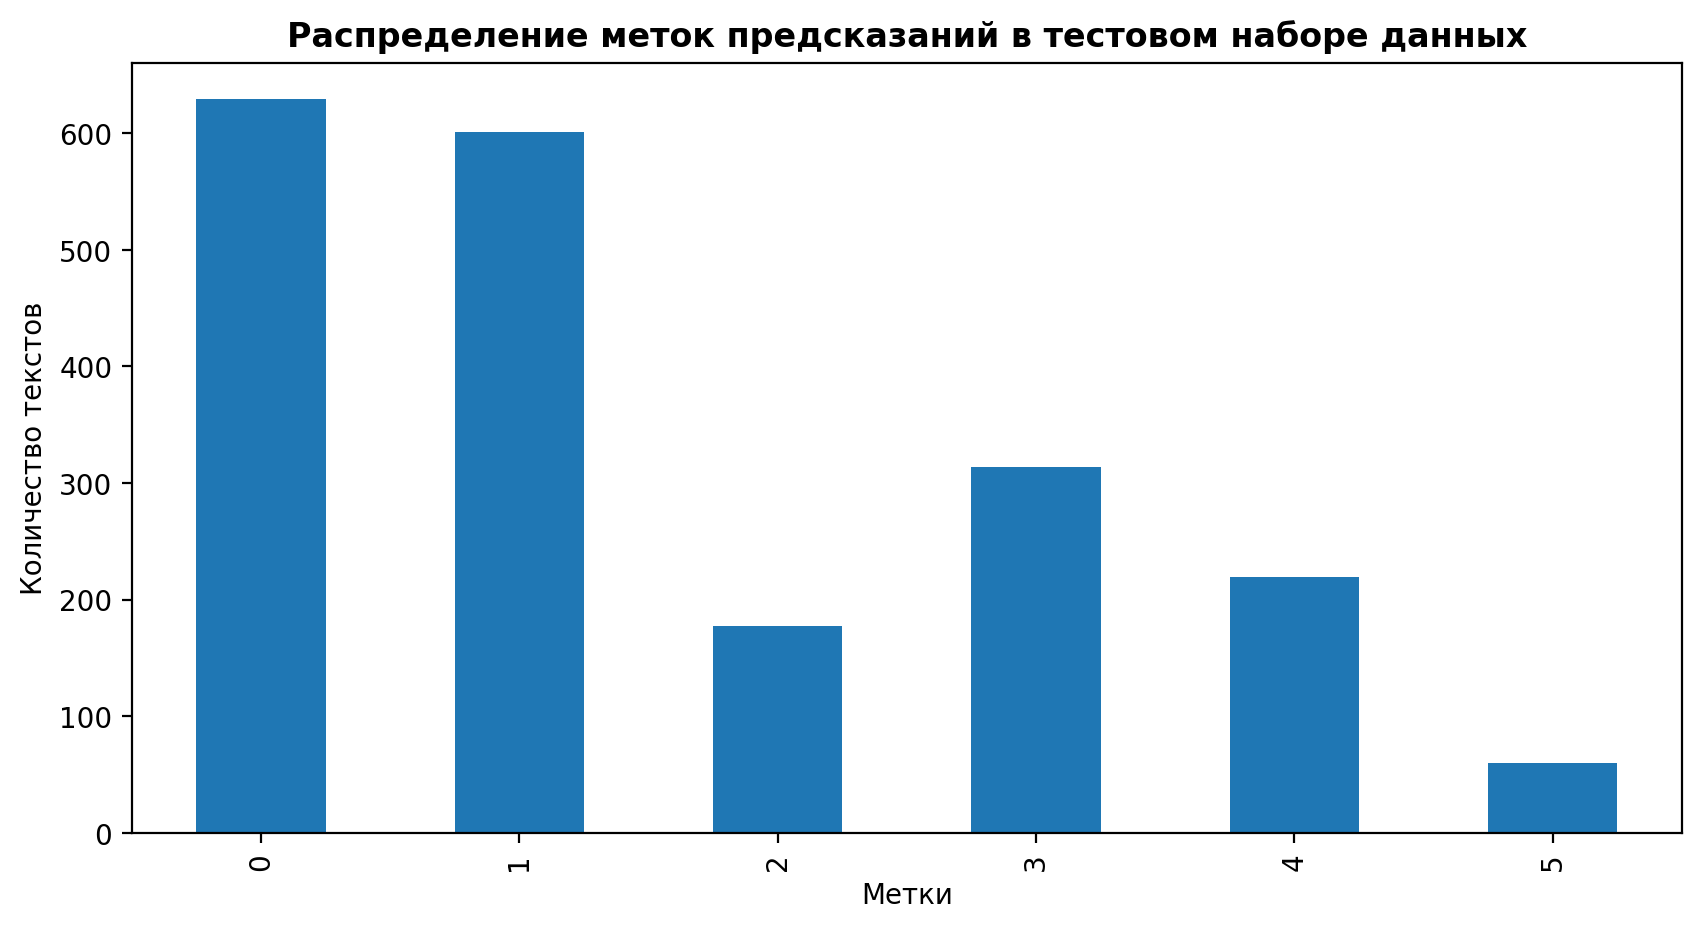

In [56]:
# Проверка баланса целевых значений
submission['label'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Распределение меток предсказаний в тестовом наборе данных', fontweight="bold")
plt.xlabel('Метки')
plt.ylabel('Количество текстов')
plt.show()


In [57]:
# Экспорт предсказаний
submission.to_csv("submission.csv", index=None)

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

# Вычисление предсказаний на проверочном наборе данных
val_predictions = [np.argmax(i) for i in model.predict(X_va_seq)]

# Вычисление метрик
precision = precision_score(y_va, val_predictions, average='macro')
recall = recall_score(y_va, val_predictions, average='macro')
f1 = f1_score(y_va, val_predictions, average='macro')
mcc = matthews_corrcoef(y_va, val_predictions)

print('Точность: {:.4f}'.format(precision))
print('Полнота: {:.4f}'.format(recall))
print('F1-мера: {:.4f}'.format(f1))
print('MCC: {:.4f}'.format(mcc))

100/100 [==============================] - 19s 187ms/step
Точность: 0.7963
Полнота: 0.7833
F1-мера: 0.7865
MCC: 0.7910


In [59]:
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# Создание и обучение токенизатора
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_tr)

# Сохранение словаря токенизатора в файл tokenizer.json
tokenizer_json = tokenizer.to_json()

# Запись словаря в файл tokenizer.json
with open("tokenizer.json", "w", encoding="utf-8") as json_file:
    json_file.write(tokenizer_json)

# Загрузка словаря из файла tokenizer.json
with open("tokenizer.json", "r", encoding="utf-8") as json_file:
    tokenizer_json = json_file.read()
    tokenizer = tokenizer_from_json(tokenizer_json)

In [60]:
model.save("emotion_model.h5")

files.download("/content/emotion_model.h5")

from google.colab import drive
drive.mount('/content/drive')

import json
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

def preprocess_text(text):
    stopwords_english = set(stopwords.words('english'))
    my_stopwords = set(["http", "'s", "n't", "'m", "'re", "'ve"])
    stopwords_english.update(my_stopwords)
    
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = text.split()
    clean_tokens = [tok for tok in tokens if tok not in stopwords_english and len(tok) > 1]
    
    clean_text = ' '.join(clean_tokens)
    return clean_text

def predict_emotion(sentence):
    # Загрузка токенизатора из файла
    with open("tokenizer.json", "r", encoding="utf-8") as json_file:
        tokenizer_json = json_file.read()
        tokenizer = tokenizer_from_json(tokenizer_json)
    
    # Предобработка предложения
    clean_sentence = preprocess_text(sentence)
    
    # Преобразование предложения в последовательность токенов
    sequence = tokenizer.texts_to_sequences([clean_sentence])
    sequence = pad_sequences(sequence, maxlen=250)
    
    # Загрузка модели
    model = load_model("emotion_model.h5")
    
    # Предсказание эмоции
    prediction = model.predict(sequence)
    emotion_labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    
    return predicted_emotion

sentence = "I am so happy right now!"
predicted_emotion = predict_emotion(sentence)
print("Predicted Emotion:", predicted_emotion)

NameError: ignored